# Exploratory Data Analysis (EDA) - Severstal: Steel Defect Dataset

This notebook provides an introductory look at the [Severstal Steel Defect Detection dataset](https://www.kaggle.com/competitions/severstal-steel-defect-detection/data) through an exploratory data analysis and visualization exercise.

**Note:** in order to run this notebook, you will need to have the the full dataset downloaded from Kaggle and saved to the `/home/cdsw/data` directory. The date is automatically downloaded and unzipped by providing your Kaggle credentials (username & API key) during the configuration step of this AMP. 

In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt

from src.data_utils import rle2mask, display_img_with_mask


%load_ext lab_black
%load_ext autoreload
%autoreload 2

## Load data

#### Annotation File

In [2]:
df = pd.read_csv("../data/train.csv")

In [3]:
df

ImageId  ClassId  \
0     0002cc93b.jpg        1   
1     0007a71bf.jpg        3   
2     000a4bcdd.jpg        1   
3     000f6bf48.jpg        4   
4     0014fce06.jpg        3   
...             ...      ...   
7090  ffcf72ecf.jpg        3   
7091  fff02e9c5.jpg        3   
7092  fffe98443.jpg        3   
7093  ffff4eaa8.jpg        3   
7094  ffffd67df.jpg        3   

                                          EncodedPixels  
0     29102 12 29346 24 29602 24 29858 24 30114 24 3...  
1     18661 28 18863 82 19091 110 19347 110 19603 11...  
2     37607 3 37858 8 38108 14 38359 20 38610 25 388...  
3     131973 1 132228 4 132483 6 132738 8 132993 11 ...  
4     229501 11 229741 33 229981 55 230221 77 230468...  
...                                                 ...  
7090  121911 34 122167 101 122422 169 122678 203 122...  
7091  207523 3 207777 9 208030 15 208283 22 208537 2...  
7092  105929 5 106177 14 106424 24 106672 33 106923 ...  
7093  16899 7 17155 20 17411 34 17667 47 17923 60 18...  
7094  30931 43 31103 127 31275 211 31489 253 31745 2...  

[7095 rows x 3 columns]

#### Image Directory

In [4]:
train_imgs = os.listdir("../data/train_images/")

In [5]:
# check for duplicates
print("NO DUPLICATES") if len(train_imgs) == len(set(train_imgs)) else print(
    "DUPLICATES FOUND"
)

NO DUPLICATES


In [6]:
print(f"There are {len(train_imgs)} total images")

There are 12568 total images


#### Combine non-defective images into dataframe

In [7]:
non_defect_imgs = list(set(train_imgs) - set(df.ImageId))
non_defect_imgs_df = pd.DataFrame(
    {"ImageId": non_defect_imgs, "ClassId": 0, "EncodedPixels": None}
)

df = pd.concat([df, non_defect_imgs_df]).reset_index(drop=True)

## Exploratory Data Analysis

In [8]:
cmap = cm.get_cmap("Paired")
class_map = {
    0: "Class 0 - No Defect",
    1: "Class 1 - Pitted Surface",
    2: "Class 2 - Inclusion",
    3: "Class 3 - Scratches",
    4: "Class 4 - Patches",
}

### How many annotations of each defect type?

[Text(0, 0, '5902'),
 Text(0, 0, '5150'),
 Text(0, 0, '897'),
 Text(0, 0, '801'),
 Text(0, 0, '247')]

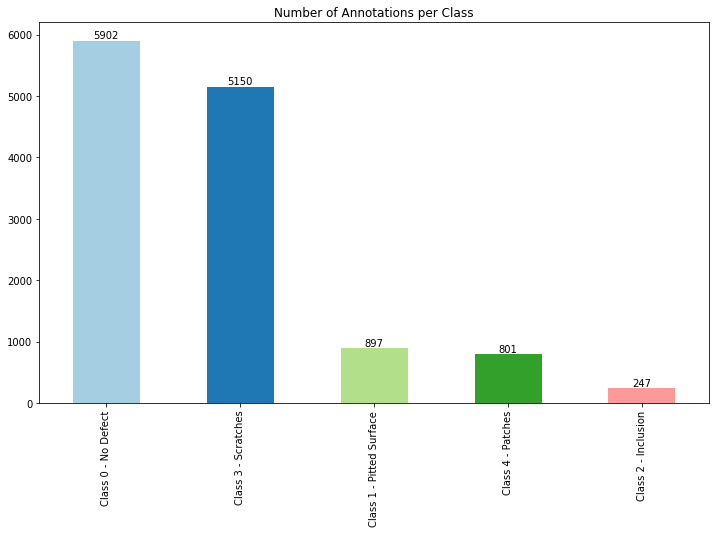

In [9]:
ax = (
    df["ClassId"]
    .value_counts()
    .rename(index=class_map)
    .plot.bar(
        title="Number of Annotations per Class",
        figsize=(12, 7),
        color=list(cmap.colors[: len(class_map.keys())]),
    )
)
ax.bar_label(ax.containers[0])

### How many images have multiple defect types?

[Text(0, 0, '6239'), Text(0, 0, '425'), Text(0, 0, '2')]

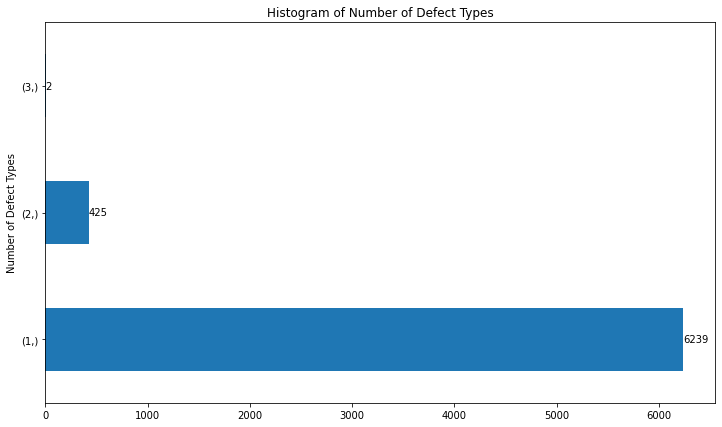

In [10]:
ax = (
    df[df.ClassId != 0][["ImageId", "ClassId"]]
    .groupby("ImageId")
    .count()
    .rename({"ClassId": "Number of Defect Types"}, axis=1)
    .value_counts()
    .plot.barh(
        title="Histogram of Number of Defect Types",
        figsize=(12, 7),
    )
)
ax.bar_label(ax.containers[0])

### How many images with 1 unique defect type by defect type?

In [11]:
image_by_class_count = (
    df[df.ClassId != 0][["ImageId", "ClassId"]].groupby("ImageId").count()
)

In [12]:
unique_defect_images = image_by_class_count[
    image_by_class_count.ClassId == 1
].index.tolist()

In [13]:
df[df.ImageId.isin(unique_defect_images)]["ClassId"].value_counts().rename(
    index=class_map
)

Class 3 - Scratches         4759
Class 1 - Pitted Surface     769
Class 4 - Patches            516
Class 2 - Inclusion          195
Name: ClassId, dtype: int64

### How many annotations per image?

- We cant currently answer this because annotations are configured as semantic segmentation rather than instance segmentation
- There might be a way to extract this information with some processing of the segmentation masks by looking at boundaries



## Visualize Segmentation Masks


**Observations:**
- Many images have negative space.
- Segmentation masks are not very precise. They often cover broad areas rather than individual defects.
- Defect class masks _can_ overlap on an image.
- Class observations:
    - Class 1 (Pitted Surface): occurs often with many, small surface area defects
    - Class 2 (Inclusion): occurs commonly as thin, vertical area defects
    - Class 3 (Scratches): have high variability in their appearance. Some are thin vertical groupings (labeled as single annotation), others look like small groupings of short horizontal lines.
    - Class 4 (Patches): have very distinct appearance. Large round patches that seem elevated from surface plane.

### Defect Class 1 - Pitted Surface

e006b532b.jpg
6caa89d4e.jpg
d2fd4e0d5.jpg
e9ccf81cf.jpg
9cee4ab2e.jpg


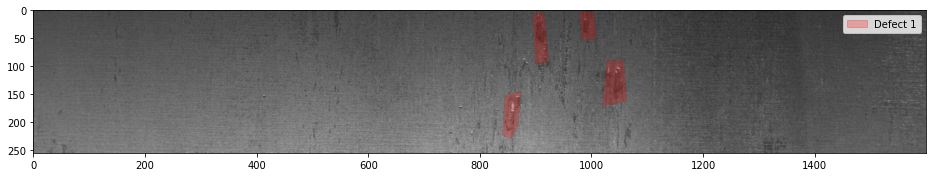

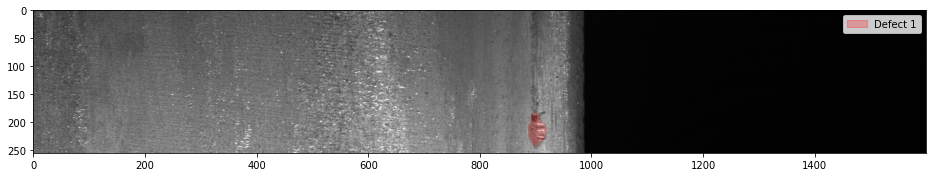

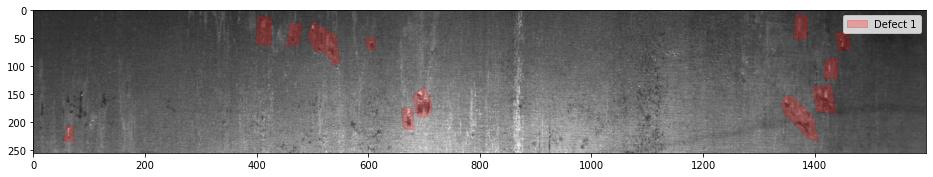

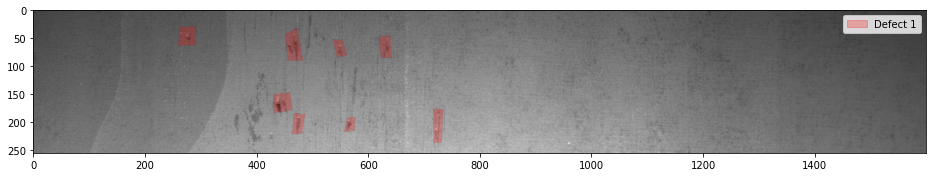

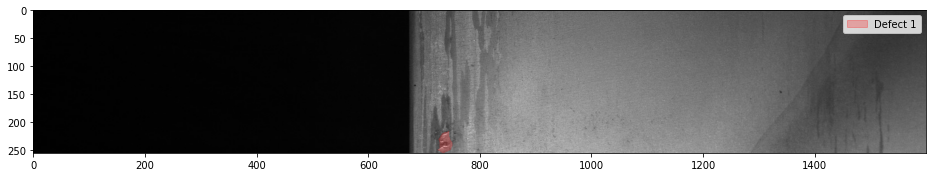

In [14]:
for i, image_id in enumerate(
    df[(df.ClassId == 1) & (df.ImageId.isin(unique_defect_images))]
    .sample(5, random_state=42)
    .ImageId.values
):
    print(image_id)
    display_img_with_mask(df, image_id)

### Defect Class 2 - Inclusion

ba0e69f45.jpg
0ebdc1277.jpg
cdc267505.jpg
78b5bc846.jpg
599251689.jpg


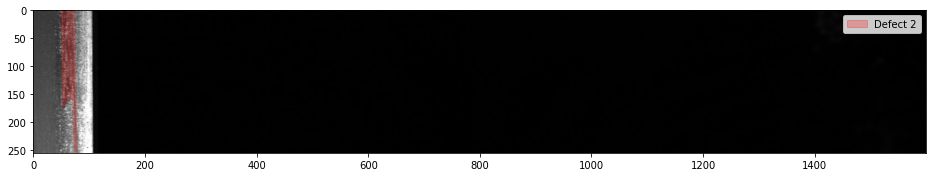

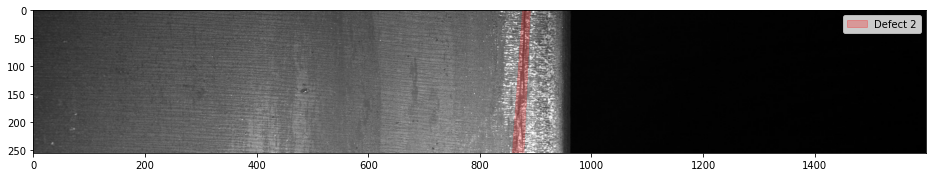

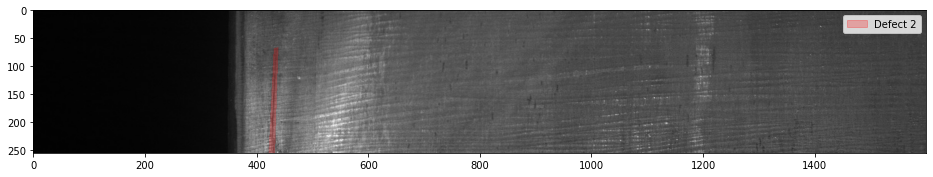

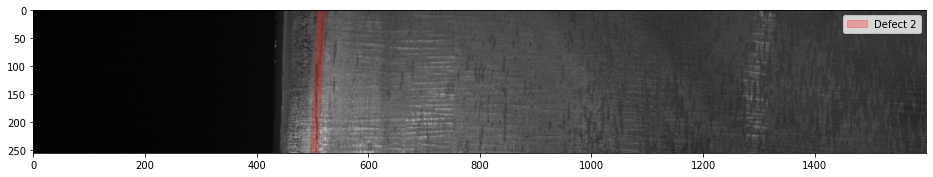

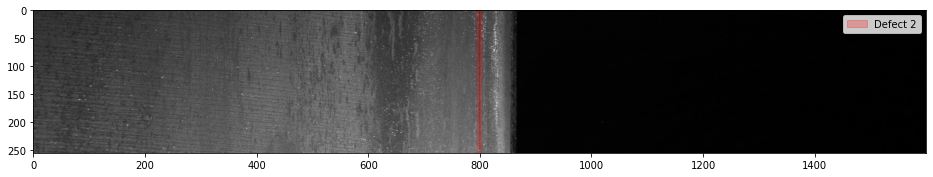

In [15]:
for i, image_id in enumerate(
    df[(df.ClassId == 2) & (df.ImageId.isin(unique_defect_images))]
    .sample(5, random_state=42)
    .ImageId.values
):
    print(image_id)
    display_img_with_mask(df, image_id)

### Defect Class 3 - Scratches

7c00478a3.jpg
112b06482.jpg
7c98d8010.jpg
19c645c25.jpg
1d56ccf70.jpg


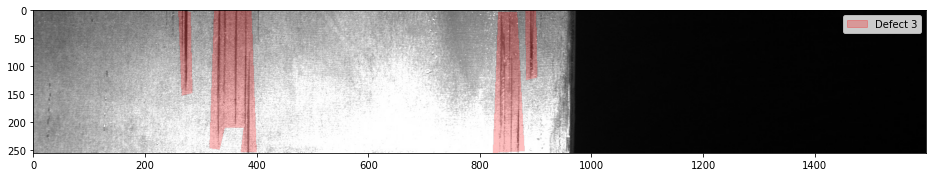

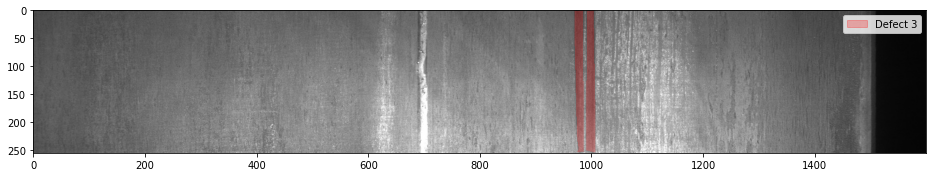

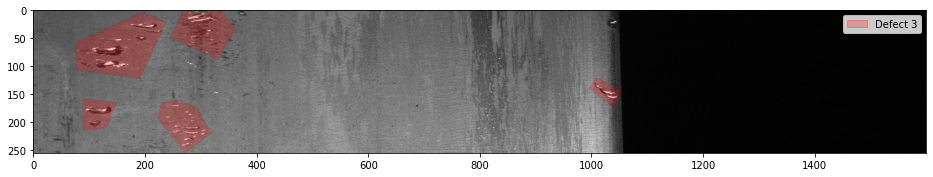

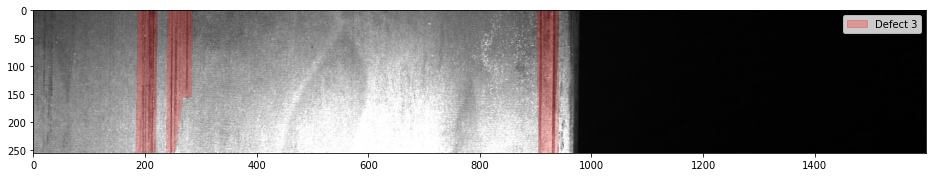

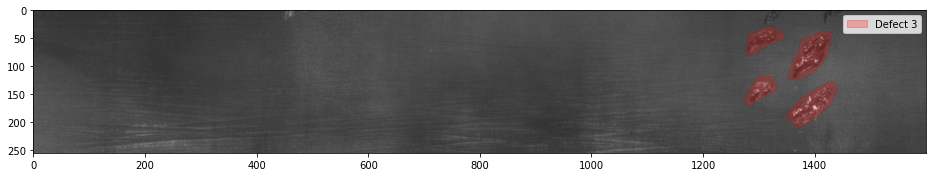

In [16]:
for i, image_id in enumerate(
    df[(df.ClassId == 3) & (df.ImageId.isin(unique_defect_images))]
    .sample(5, random_state=42)
    .ImageId.values
):
    print(image_id)
    display_img_with_mask(df, image_id)

### Defect Class 4 - Patches

9699f82fe.jpg
f444c57a7.jpg
d5a8b7ba4.jpg
495d5828b.jpg
f503817dd.jpg


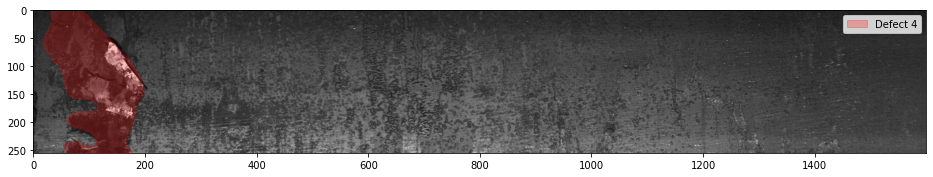

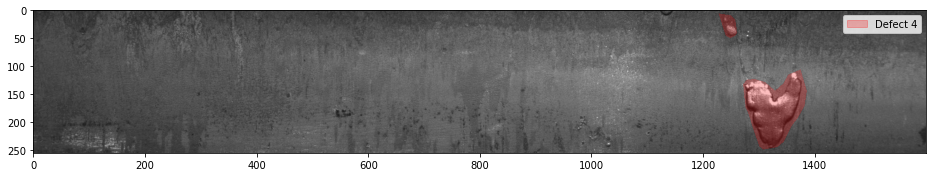

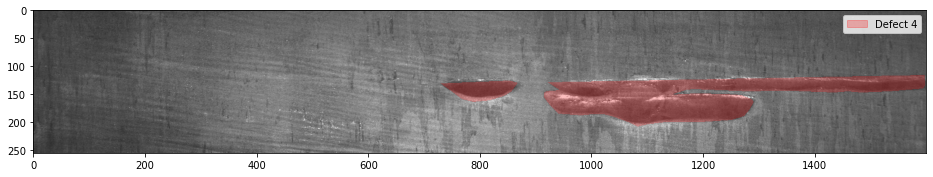

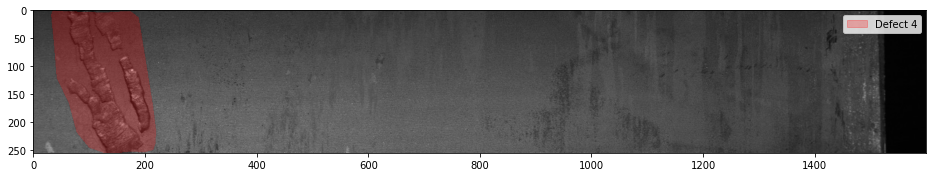

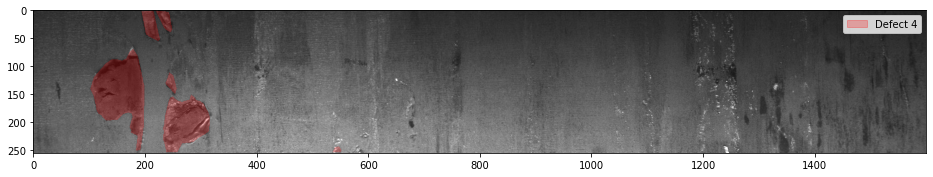

In [17]:
for i, image_id in enumerate(
    df[(df.ClassId == 4) & (df.ImageId.isin(unique_defect_images))]
    .sample(5, random_state=42)
    .ImageId.values
):
    print(image_id)
    display_img_with_mask(df, image_id)

## Multiple Defect Classes per Image

d869026cd.jpg
be3b49756.jpg
2930b4f52.jpg
4aa9afc78.jpg
81b6f3cca.jpg
eb5d79866.jpg
d7749f865.jpg
5b9b3c297.jpg
d7a6b31ea.jpg
f806c9662.jpg


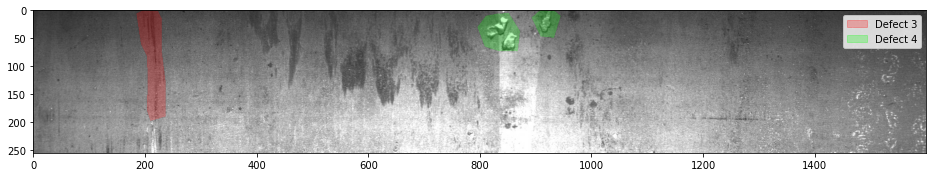

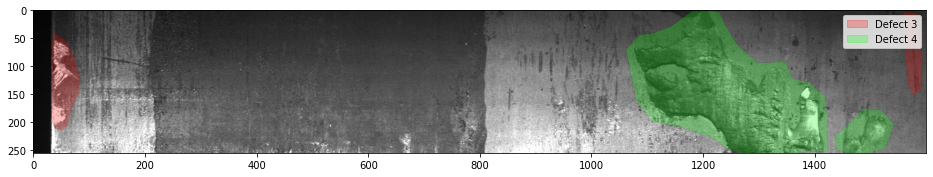

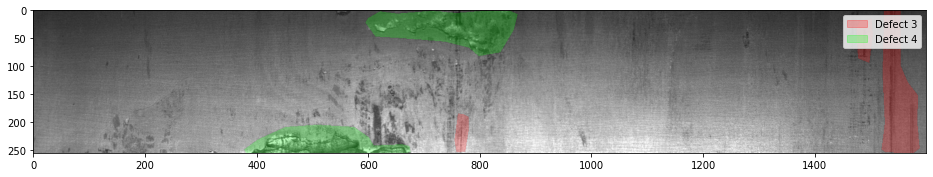

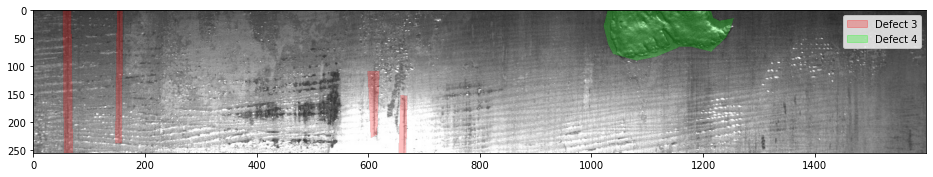

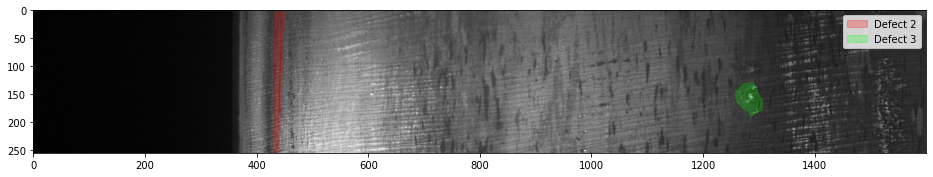

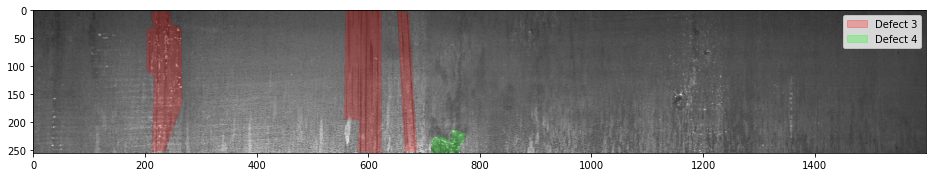

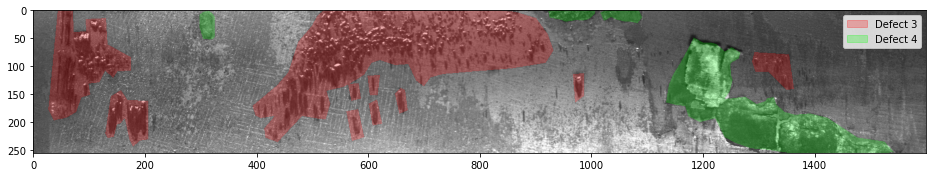

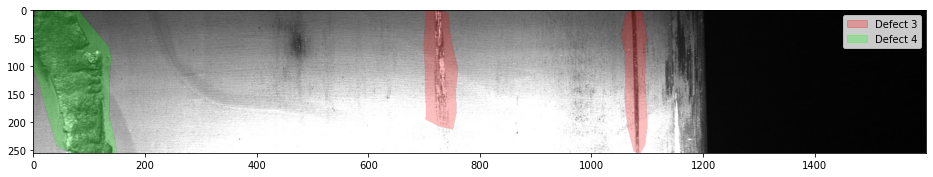

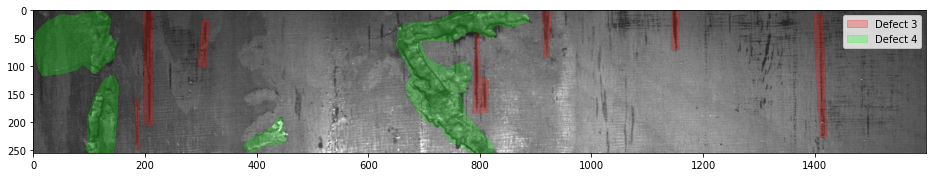

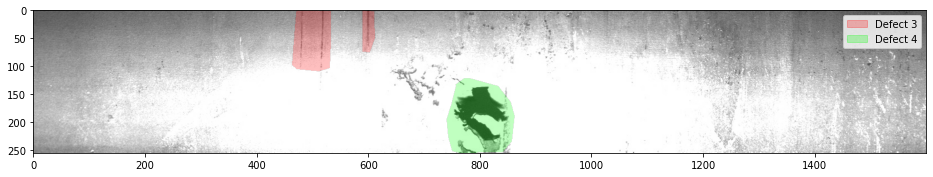

In [18]:
for i, image_id in enumerate(
    df[(df.ClassId != 0) & (~df.ImageId.isin(unique_defect_images))]
    .sample(10, random_state=42)
    .ImageId.values
):
    print(image_id)
    display_img_with_mask(df, image_id)

**If this documentation includes code, including but not limited to, code examples, Cloudera makes this available to you under the terms of the Apache License, Version 2.0, including any required notices. A copy of the Apache License Version 2.0 can be found [here](https://opensource.org/licenses/Apache-2.0).**